# Building BasicNN using Pytorch and Lightning 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt
#import numpy as np
import seaborn as sns

### The Neural Network Class ()
This class definition inherits from `LightningModule`, combining the initialization, forward pass, optimization setup, and training step into one location

In [41]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False) 
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        # Set requires_grad=True so PyTorch optimizes this parameter [8]
        self.final_bias = nn.Parameter(torch.tensor(-16.0), requires_grad=False) 

    def forward(self, input): ## forward() takes an input value and runs it though the neural network  
        
        ## the next three lines implement the top of the neural network (using the top node in the hidden layer).
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01
        
        ## the next three lines implement the bottom of the neural network (using the bottom node in the hidden layer).
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11
        
        ## here, we combine both the top and bottom nodes from the hidden layer with the final bias.
        input_to_final_relu = (scaled_top_relu_output 
                               + scaled_bottom_relu_output 
                               + self.final_bias)
        
        output = F.relu(input_to_final_relu)
    
        return output # output is the predicted effectiveness for a drug dose.


In [42]:
model = BasicLightning()

for name,param in model.named_parameters():
    print(name, param.data)

w00 tensor(1.7000)
b00 tensor(-0.8500)
w01 tensor(-40.8000)
w10 tensor(12.6000)
b10 tensor(0.)
w11 tensor(2.7000)
final_bias tensor(-16.)


In [43]:
input_doses = torch.linspace(start=0, end=1, steps=11)

input_doses 

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

Text(0, 0.5, 'Effectiveness')

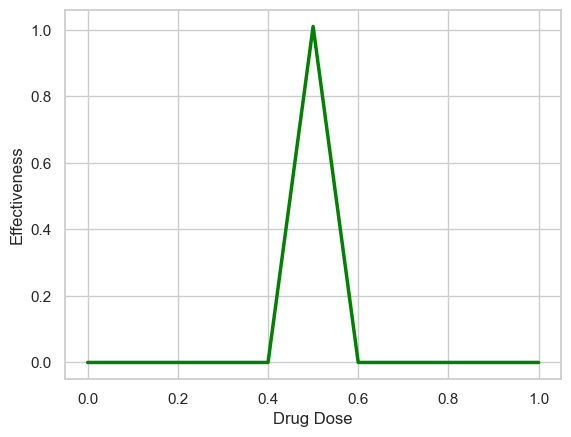

In [44]:
model = BasicLightning()
output_values = model(input_doses)

sns.set(style="whitegrid")
sns.lineplot(x=input_doses, y=output_values,color='green',linewidth=2.5)
plt.xlabel("Drug Dose")
plt.ylabel("Effectiveness")

## Optimising a parameter in the Neural Network 

In [48]:
class BasicLightningTrain(L.LightningModule):
    def __init__(self):
       super().__init__()
       L.seed_everything(seed=42)

       self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
       self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
       self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

       self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
       self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
       self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

       self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

       self.learning_rate = 0.01

    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = (scaled_top_relu_output 
                               + scaled_bottom_relu_output 
                               + self.final_bias)

        output = F.relu(input_to_final_relu)

        return output
    
    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        predictions = self.forward(inputs)
        loss = (predictions-targets)**2  # MSE loss
        self.log("train_loss", loss)
        return loss

Seed set to 42


Text(0, 0.5, 'Effectiveness')

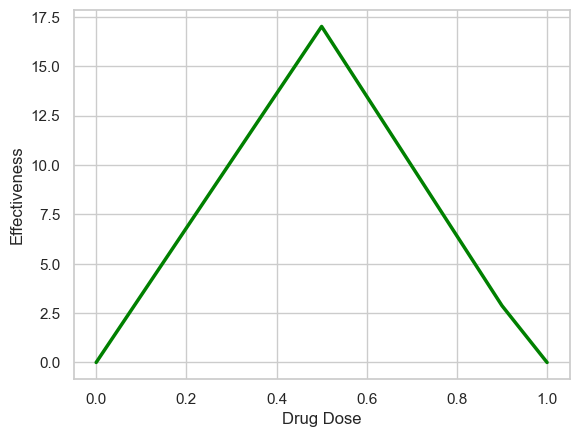

In [ ]:
model = BasicLightningTrain()
output_values = model(input_doses)

sns.set(style="whitegrid")
sns.lineplot(x=input_doses, y=output_values.detach(),color='green',linewidth=2.5)
plt.xlabel("Drug Dose") 
plt.ylabel("Effectiveness")

The graph shows that when the dose is **0.5**, the output from the unoptimized neural network is **17**, which is way too high, since the output value should be **1**. So, now that we have a parameter we can optimize, let's create some training data that we can use to optimize it. **NOTE:** Instead of just jamming some tensors into our neural network for training, **Lightning** requires us to wrap the training data in a `DataLoader`, which provides a lot of nice features. For example, if we had a large dataset, a `DataLoader` gives us a super easy way to access the data in batches instead of all at once. This is critical when we have more data than RAM to store it in. A `DataLoader` can also shuffle the data for us each epoch and makes it easy to only use a fraction of the data if we want to do a quick and rough training for debugging purposes.

In [50]:
inputs = torch.tensor([0.0,0.5,1.0]*100)
targets = torch.tensor([0.0,1.0,0.0]*100)


dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset)

And now that we have some training data, the first thing we need to do is find the optimal **Learning Rate** for gradient descent. We do this by creating a **Lightning** `Trainer` and using it to call `tuner.lr_find()` to find an improved learning rate.

In [52]:
model = BasicLightningTrain()

trainer = L.Trainer(max_epochs=34, accelerator="auto", devices="auto")

tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(model,
                                train_dataloaders=dataloader, # the training data
                                min_lr=0.001, # minimum learning rate
                                max_lr=1.0,   # maximum learning rate
                                early_stop_threshold=None) # setting this to "None" tests all 100 candidate rates

new_lr = lr_find_results.suggestion() ## suggestion() returns the best guess for the optimal learning rate

print(f"lr_find_results.suggestion(): {new_lr:.5f} for the learning rate")

model.learning_rate = new_lr


Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 237.28it/s]
Restoring states from the checkpoint path at c:\Users\home\Desktop\Semester 3\Foundations_Machine_learning\FML-Course-problems\.lr_find_ffe6e3d4-8768-4c75-addf-359ad3d0654c.ckpt
Restored all states from the checkpoint at c:\Users\home\Desktop\Semester 3\Foundations_Machine_learning\FML-Course-problems\.lr_find_ffe6e3d4-8768-4c75-addf-359ad3d0654c.ckpt
Learning rate set to 0.002137962089502232


lr_find_results.suggestion(): 0.00214 for the learning rate


Now that we have an improved training rate, let's train the model to optimize `final_bias`.

In [53]:
trainer.fit(model, train_dataloaders=dataloader)

print(model.final_bias.data)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 33: 100%|██████████| 300/300 [00:02<00:00, 121.18it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=34` reached.


Epoch 33: 100%|██████████| 300/300 [00:02<00:00, 120.52it/s, v_num=1]
tensor(-16.0098)


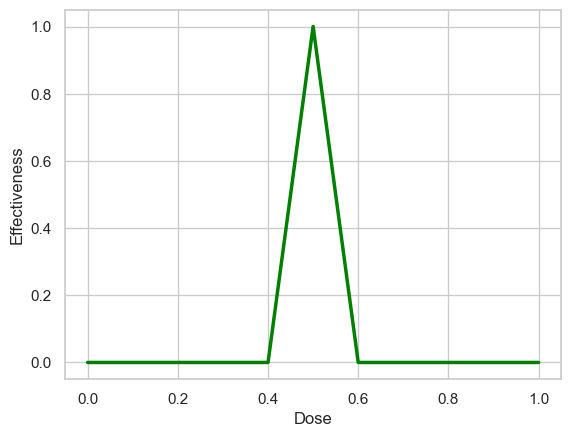

In [54]:
## run the different doses through the neural network
output_values = model(input_doses)

## set the style for seaborn so that the graph looks cool.
sns.set(style="whitegrid")

## create the graph (you might not see it at this point, but you will after we save it as a PDF).
sns.lineplot(x=input_doses, 
             y=output_values.detach(), ## NOTE: we call detach() because final_bias has a gradient
             color='green', 
             linewidth=2.5)

## now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.savefig('BasicLightningTrain_optimized.pdf')
